In [1]:
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
import nltk.metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
import numpy as np

nltk.download('vader_lexicon')
nltk.download('stopwords')

sia = SentimentIntensityAnalyzer()



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rehan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rehan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

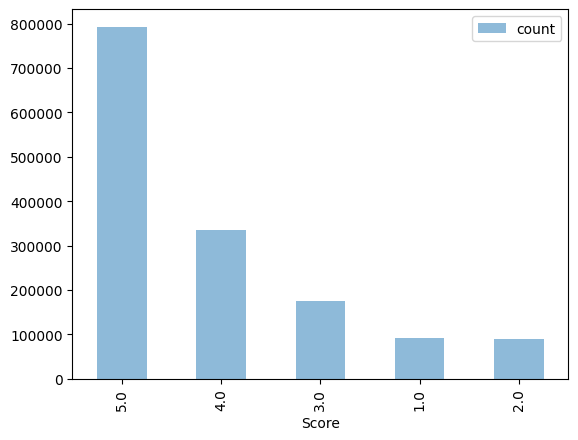


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [3]:
trainingSet.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0


In [4]:
def calculate_sentiment(text):
    if isinstance(text, str):
        sentiment = sia.polarity_scores(text)
        return sentiment['compound']
    else:
        return 0

In [5]:
# Adjust scores to start from 0 instead of 1
trainingSet['Score'] = trainingSet['Score'] - 1

In [6]:
# Shows new scores
trainingSet.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,4.0
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",4.0
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,3.0
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,4.0
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",2.0


In [7]:
def user_features(df):
    user_stats = df.groupby('UserId').agg({'Score': ['mean', 'std', 'count']}).reset_index()
    user_stats.columns = ['UserId', 'user_mean_score', 'user_std_score', 'user_review_count']
    
    user_stats['user_std_score'] = user_stats['user_std_score'].fillna(0)
    df = df.merge(user_stats, on='UserId', how='left')
    
    return df

In [8]:
def product_features(df):
    product_stats = df.groupby('ProductId').agg({'Score': ['mean', 'std', 'count']}).reset_index()
    product_stats.columns = ['ProductId', 'product_mean_score', 'product_std_score', 'product_review_count']
    
    product_stats['product_std_score'] = product_stats['product_std_score'].fillna(0)
    df = df.merge(product_stats, on='ProductId', how='left')
    
    return df

In [9]:
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Review_Length'] = df['Text'].str.len()
    df['Review_Length'] = df['Review_Length'].fillna(0)

    df['Sentiment_Score'] = df['Text'].apply(calculate_sentiment)
    df['Sentiment_Summary'] = df['Summary'].apply(calculate_sentiment)

    # Add user-based and product-based features
    df = user_features(df)
    df = product_features(df)
    
    df['user_mean_score'] = df['user_mean_score'].fillna(df['user_mean_score'].mean())
    df['user_std_score'] = df['user_std_score'].fillna(df['user_std_score'].mean())
    df['user_review_count'] = df['user_review_count'].fillna(1)

    df['product_mean_score'] = df['product_mean_score'].fillna(df['product_mean_score'].mean())
    df['product_std_score'] = df['product_std_score'].fillna(df['product_std_score'].mean())
    df['product_review_count'] = df['product_review_count'].fillna(1)

    return df


if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    train = add_features_to(trainingSet)

    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

In [12]:
from sklearn.model_selection import GridSearchCV

features = [
    'Sentiment_Score', 
    'Sentiment_Summary', 
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Review_Length',
    'user_mean_score',
    'user_std_score',
    'user_review_count',
    'product_mean_score',
    'product_std_score',
    'product_review_count'
]

# Create a parameter grid to search for best hyperparameters for XGBClassifier
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Create a XGB model to tune with GridSearchCV and fit it to the data using 3-fold cross validation
model = XGBClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=3
)

grid_search.fit(X_train_select, Y_train)



Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.623 total time=  14.8s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.623 total time=  14.6s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=0.622 total time=  13.7s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0;, score=0.623 total time=   9.8s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0;, score=0.623 total time=   9.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0;, score=0.622 total time=   9.6s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.632 total time=  20.3s
[CV 2/3

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=3)

In [13]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
grid_search.best_score_

0.6901028271865925

In [15]:
X_submission['Score'] = grid_search.predict(X_submission_select)

# Add 1 back to the predictions to match the original scale
X_submission['Score'] = X_submission['Score'] + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv('./data/submission-optimized-v2.csv', index=False)

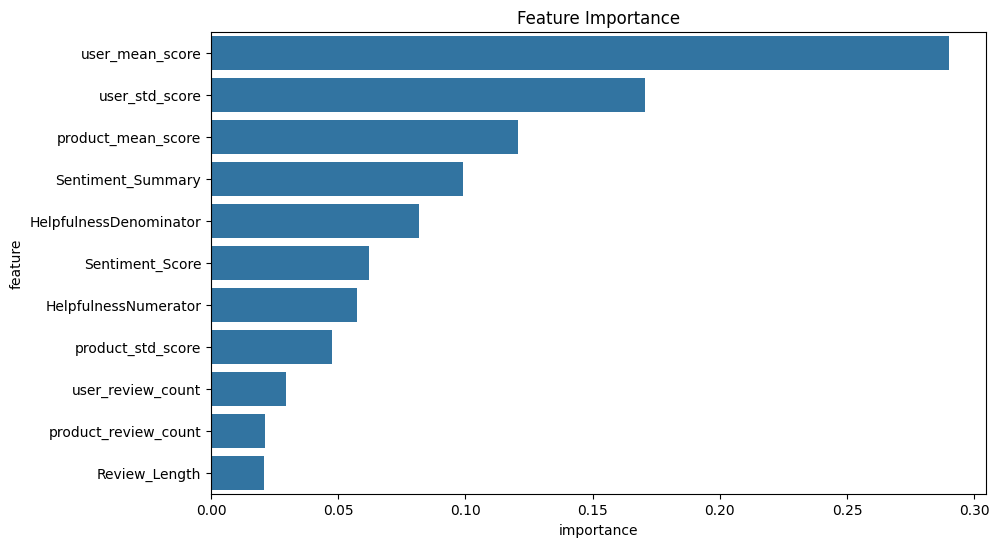

In [16]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': grid_search.best_estimator_.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


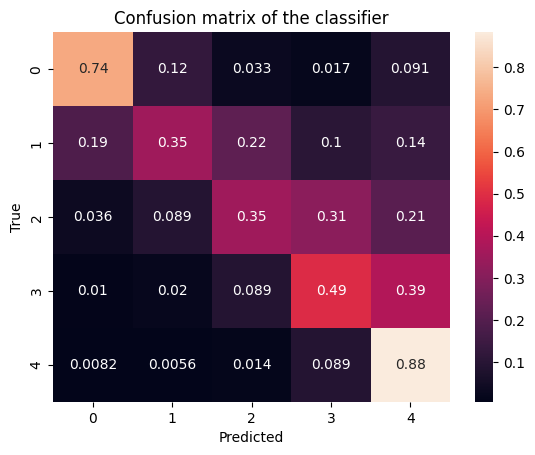

In [19]:
# Plot confusion matrix
conf_matrix = confusion_matrix(Y_test, grid_search.predict(X_test_select) , normalize='true')
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()